In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel

from scipy.optimize import curve_fit
from scipy import stats

import dataloader
import preprocessing
import data_augmentation


# Load data

In [34]:
# Load preprocessed ERSP data
ERSP_all, tmp_all, freqs = dataloader.load_data()

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)


In [8]:
# Load raw data
# Read pickle file
with open('./ERSP_from_raw.data', 'rb') as fp:
    dict_ERSP = pickle.load(fp)
    
ERSP_all, tmp_all, freqs, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
print('Shape of ERSP_all: ', ERSP_all.shape)
print('Shape of tmp_all: ', tmp_all.shape)
print('Shape of freqs: ', freqs.shape)
print('Shape of t: ', t.shape)

Shape of ERSP_all:  (1084, 12, 57, 172)
Shape of tmp_all:  (1084,)
Shape of freqs:  (57,)
Shape of t:  (172,)


# Data preprocessing

In [64]:
#ERSP_all, tmp_all = preprocessing.remove_trials(ERSP_all, tmp_all, 25)
ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

## Remain original ERSP

In [65]:
num_epoch = ERSP_all.shape[0]
method = 3 # 1,2,3

if method != 3:
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    
else:
    '''
    # Concatenate over channels (PCA -> LDA)
    ERSP_all = ERSP_all.reshape((num_epoch, -1))
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    '''
    # Average power over channels (LDA directly)
    ERSP_all = np.mean(ERSP_all, axis=2)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    '''
    ERSP_all = preprocessing.bandpower(ERSP_all, freqs, 5, 15)
    print('Shape of ERSP_all: ', ERSP_all.shape)
    

Shape of ERSP_all:  (452, 12)


## Trim mean

In [4]:
ERSP_all, new_SLs = preprocessing.trimMean(ERSP_all, SLs, freqs)
Y = preprocessing.make_target(new_SLs)

method = 3

## Bandpower

In [4]:
ERSP_1 = preprocessing.bandpower(ERSP_all, freqs, 5, 10)
ERSP_2 = preprocessing.bandpower(ERSP_all, freqs, 10, 15)
ERSP_all = np.concatenate((ERSP_1, ERSP_2), axis=1)

threshold = np.mean(SLs)+np.std(SLs)
print(threshold)
Y = preprocessing.make_target(SLs, threshold)

method = 3

25.554513197351692


# Holdout Method

## Split data

In [5]:
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(ERSP_all, Y, test_size=0.1, random_state=42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (406, 1368)
X_test shape :  (46, 1368)


## PCA (1) Largest eigenvalues

In [5]:
# Apply PCA to training data and testing data
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

NameError: name 'X_train' is not defined

## PCA (2) Most correlated

In [5]:
def PCA_corr(X_train, X_test, Y_train):
    # PCA fit
    num_train = X_train.shape[0]
    mean_X = 1/num_train * np.dot(X_train.T, np.ones((num_train,1))).T
    cen_X_train = X_train - mean_X
    cov_X_train = 1/num_train * np.dot(cen_X_train.T, cen_X_train)
    w, v = np.linalg.eig(cov_X_train)

    # Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(w)[::-1]
    sorted_v = v[:, sorted_indices]
    sorted_w = np.sort(w)[::-1]

    # Retain PCs with 80% eigenvalues
    ratios = np.add.accumulate(sorted_w.real)/np.sum(sorted_w.real)
    num_PCs = np.sum(ratios<=0.8)
    PCs = sorted_v[:, :num_PCs]

    # PCA predict
    X_train = np.dot(cen_X_train, PCs)

    # Find two PCs correlated most strongly with SLs
    corr_coef = np.zeros(num_PCs)
    for i in range(num_PCs):
        corr_coef[i] = abs(np.corrcoef(X_train[:,i], Y_train[:,1])[0,1])

    #print(corr_coef)
    max_1_index = np.argmax(corr_coef)
    #print('Max: ', max_1_index)
    corr_coef[max_1_index] = 0
    max_2_index = np.argmax(corr_coef)
    #print('Second: ', max_2_index)
    PC_2 = sorted_v[:, [max_1_index, max_2_index]]


    # PCA predict
    X_train = abs(np.dot(cen_X_train, PC_2))
    X_test = abs(np.dot(X_test-mean_X, PC_2))

    #print('X_train shape : ', X_train.shape)
    #print('X_test shape : ', X_test.shape)
    
    return X_train, X_test

In [7]:
X_train, X_test = PCA_corr(X_train, X_test, Y_train)

[0.10016149 0.13321825 0.19431854 0.1501953  0.1506912  0.05088907
 0.14942456 0.12343108 0.06527064 0.0030398  0.02589858 0.06059784
 0.06922075 0.04778581 0.0834417  0.08851105 0.09370633 0.03329117
 0.08084067 0.00824471 0.00701375 0.09780048 0.05044458 0.0233989 ]
Max:  2
Second:  4


In [8]:
# Sort SLs in increasing order
sorted_indices = np.argsort(Y_train[:,1])
sorted_x = X_train[sorted_indices, :]
sorted_y = Y_train[sorted_indices, :]

# Curve fitting
def func(X, a, b, c):
    x1, x2 = X
    return a + b*x1 + c*x2

xdata = (sorted_x[:,0], sorted_x[:,1])
ydata = sorted_y[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

Text(0.5, 1.0, 'r = 0.043601')

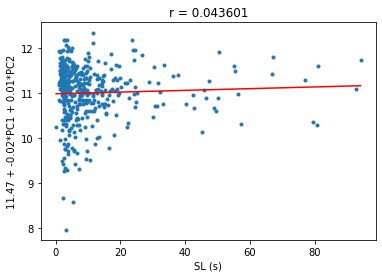

In [9]:
# Plot them
y_reg = func(xdata, popt[0], popt[1], popt[2])
plt.scatter(ydata, y_reg, marker = '.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ydata, y_reg)
y_range = np.linspace(np.min(ydata), np.max(ydata), 100)
plt.plot(y_range, slope*y_range+intercept, 'r-')

plt.xlabel('SL (s)')
plt.ylabel('%.2f + %.2f*PC1 + %.2f*PC2'%(popt[0],popt[1],popt[2]))
plt.title('r = %f'%(np.corrcoef(y_reg, ydata)[0,1]))


# Leave-one-out cross validation

In [ ]:
X_all = ERSP_all

test_acc_SL = []
thresholds = list(range(1,50))

for threshold in thresholds:
    Y = preprocessing.make_target(SLs, float(threshold))
    
    train_acc_list = []
    test_acc_list = []
    loo = LeaveOneOut()
    for i, (train_index, test_index) in enumerate(loo.split(X_all)):

        # No trim mean
        # Split data
        X_train, X_test = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        if method == 1:
            pca = PCA(n_components=2)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            # PCA
            X_train, X_test = PCA_corr(X_train, X_test, Y_train)

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]

        '''
        # Trim mean after removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        X_train, new_SLs = trimMean(X_train, SLs[train_index], freqs)
        X_test = bandpower(X_test, freqs, 10, 15)

        # Let mean of SLs be the threshold
        threshold = np.mean(new_SLs) 
        Y_train = np.asarray(new_SLs >= threshold, float)
        Y_test = np.asarray(SLs[test_index] >= threshold, float)
        '''

        '''
        # Trim mean before removing the validation data
        # Split data
        X_train, X_test = X_all[train_index], X_all[test_index]
        Y_train, Y_test = Y[train_index, :], Y[test_index, :]

        # Decompose Y
        Y_train = Y_train[:,0]
        Y_test = Y_test[:,0]
        '''

        # LDA
        clf = svm.SVC()
        clf.fit(X_train, Y_train)

        num_train = len(Y_train)
        pred_train = clf.predict(X_train)
        train_acc = np.sum(pred_train == Y_train)/num_train*100
        #print('Training Accuracy : %f'%(train_acc))
        train_acc_list.append(train_acc)

        num_test = len(Y_test)
        pred_test = clf.predict(X_test)
        test_acc = np.sum(pred_test == Y_test)*100
        #print('Testing Accuracy : %f'%(test_acc))
        test_acc_list.append(test_acc)

        # print('Iteration %d: (%f, %f)'%(i, train_acc, test_acc))
        
    print('Threshold %d: %f'%(threshold, sum(test_acc_list)/len(test_acc_list)))
    test_acc_SL.append(sum(test_acc_list)/len(test_acc_list))
    

In [6]:
test_acc_array = np.asarray(test_acc_list)
false_trials = SLs[np.where(test_acc_array==0)[0]]
true_trials = SLs[np.where(test_acc_array==100)[0]]
print('False trials, Min: %f, Max: %f'%(np.min(false_trials), np.max(false_trials)))
print('True trials, Min: %f, Max: %f'%(np.min(true_trials), np.max(true_trials)))

False trials, Min: 26.693359, Max: 94.105469
True trials, Min: 0.152344, Max: 25.238281


In [6]:
print('Training accuracy: %f'%(sum(train_acc_list)/len(train_acc_list)))
print('Testing accuracy: %f'%(sum(test_acc_list)/len(test_acc_list)))

Training accuracy: 91.150442
Testing accuracy: 91.150442


Text(0, 0.5, 'Accuracy (%)')

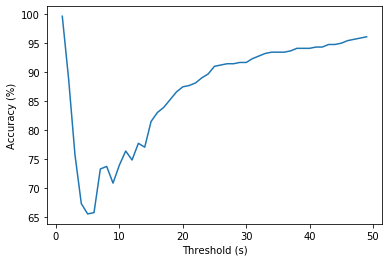

In [9]:
plt.plot(thresholds, test_acc_SL)
plt.xlabel('Threshold (s)')
plt.ylabel('Accuracy (%)')

In [6]:
ratios = []
for threshold in thresholds:
    ratio = max(np.sum(SLs<=threshold), np.sum(SLs>threshold))/len(SLs)
    ratios.append(ratio*100)

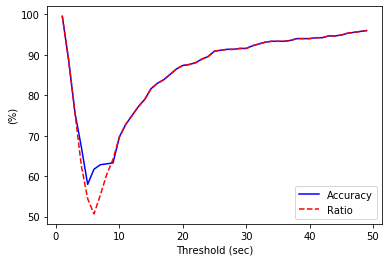

In [7]:
plt.plot(thresholds, test_acc_SL, 'b-', thresholds, ratios, 'r--')
plt.xlabel('Threshold (sec)')
plt.ylabel('(%)')
plt.legend(('Accuracy', 'Ratio'))

# Regression

In [9]:
def standard_error(pred, target):
    
    assert pred.shape[0] == target.shape[0]
    
    return (np.sum( np.power(pred-target,2) )/len(pred))**0.5

def plot_scatter(true, pred, fileName=None):
    
    sort_indices = np.argsort(true)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(range(len(true)), true[sort_indices], 'r.', range(len(true)), pred[sort_indices], 'b.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Solution latency')
    axs[0].legend(('True', 'Pred'))
    
    max_value = np.max(np.hstack((true, pred)))
    axs[1].scatter(true, pred, marker='.')
    axs[1].plot(range(int(max_value)),range(int(max_value)), 'r')
    axs[1].set_xlabel('True')
    axs[1].set_ylabel('Pred')
    axs[1].set_xlim([0, max_value])
    axs[1].set_ylim([0, max_value])
    
    if fileName is not None:
        plt.savefig('./results/classical/%s_scatter.png'%(fileName))
        
def plot_residual(true, pred, fileName=None):
    
    record = range(len(true))
    residual = pred-true
    print('Mean of residual: %.3f'%(np.mean(pred-true)))
    
    fig, axs = plt.subplots(2,1, figsize=(8,5))
    axs[0].scatter(record, pred-true, marker='.')
    axs[0].set_xlabel('Record number')
    axs[0].set_ylabel('Residual')
    axs[0].set_title('Versus record number')
    
    axs[1].scatter(true, pred-true, marker='.')
    axs[1].set_xlabel('Target')
    axs[1].set_ylabel('Residual')
    axs[1].set_title('Versus target')
    
    fig.tight_layout(pad=2.0)
    
    if fileName is not None:
        plt.savefig('./results/classical/%s_residual.png'%(fileName))
        
def regression(X_train, Y_train, X_test, Y_test, regressor):
    
    results = regressor.fit(X_train,Y_train)
    pred_train = regressor.predict(X_train)
    pred_test = regressor.predict(X_test)
    
    train_std = mean_squared_error(Y_train, pred_train)**0.5
    test_std = mean_squared_error(Y_test, pred_test)**0.5
    train_r2 = r2_score(Y_train, pred_train)
    test_r2 = r2_score(Y_test, pred_test)
    
    return results, train_std, test_std, train_r2, test_r2, pred_train, pred_test

## Cross validation

In [10]:
mode_cv = 'KFold'
#aug_methods = ['Original', 'undersampling', 'SMOTER', 'add_noise']
aug_methods = ['Original']
center_flag = True
method = 2
rgr_method = 1
num_results = len(aug_methods)

if mode_cv == 'KFold':
    num_fold = 10
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=23)
    
else:
    num_fold = ERSP_all.shape[0]
    kf = LeaveOneOut()
    
true_Y = np.zeros(tmp_all.shape[0])
pred_Y = np.zeros((tmp_all.shape[0], num_results))

train_std = np.zeros((num_fold, num_results))
test_std = np.zeros((num_fold, num_results))
train_r2 = np.zeros((num_fold, num_results))
test_r2 = np.zeros((num_fold, num_results))
train_base = np.zeros(num_fold)
test_base = np.zeros(num_fold)
train_base_r2 = np.zeros(num_fold)
test_base_r2 = np.zeros(num_fold)

curr_test = 0

for i, (train_index, test_index) in enumerate(kf.split(ERSP_all)):
    print('---Iteration %d---\n'%(i))
    
    # Standardize data
    X_all, Y = preprocessing.standardize(ERSP_all, tmp_all, train_indices=train_index, threshold=5.0)
    
    '''
    # Select correlated ERSP
    X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.95, train_indices=train_index)
    select.append(select_indices)
    '''
    
    # Flatten X_all
    X_all = X_all.reshape((X_all.shape[0],-1))
    
    # Split data
    X_train, X_test_ori = X_all[train_index, :], X_all[test_index, :]
    Y_train, Y_test_ori = Y[train_index], Y[test_index]
    
    # Data augmentation
    aug_X_train, aug_Y_train = {}, {}
    
    aug_X_train['Original'], aug_Y_train['Original'] = X_train.copy(), Y_train.copy()
    if 'undersampling' in aug_methods:
        aug_X_train['undersampling'], aug_Y_train['undersampling'] = data_augmentation.aug(X_train, Y_train, 'undersampling')
    if 'SMOTER' in aug_methods:
        aug_X_train['SMOTER'], aug_Y_train['SMOTER'] = data_augmentation.aug(X_train, Y_train, 'SMOTER')
    if 'add_noise' in aug_methods:
        aug_X_train['add_noise'], aug_Y_train['add_noise'] = data_augmentation.aug(X_train, Y_train, 'add_noise', (10,1))
    
    for i_aug, aug_method in enumerate(aug_methods):
        
        X_train, Y_train = aug_X_train[aug_method], aug_Y_train[aug_method]
        X_test, Y_test = X_test_ori.copy(), Y_test_ori.copy()
        
        # Standardize before PCA
        if center_flag:
            X_train, X_test = preprocessing.center(X_train, X_test)
        
        # PCA
        if method == 1:
            pca = PCA(n_components=10)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif method == 2:
            X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=10)
        elif method == 3:
            X_train = X_train.reshape((X_train.shape[0],12,-1))
            X_test = X_test.reshape((X_test.shape[0],12,-1))
            
            X_train = preprocessing.bandpower(X_train, freqs, 5, 15)
            X_test = preprocessing.bandpower(X_test, freqs, 5, 15)
            
            X_train = X_train.reshape((X_train.shape[0],-1))
            X_test = X_test.reshape((X_test.shape[0],-1))
            
        if rgr_method == 1:
            rgr = LinearRegression()
        elif rgr_method == 2:
            rgr = Ridge(alpha=0.1)
        elif rgr_method == 3:
            
            kernel = RBF(10, (1e-2,1e2)) + ConstantKernel(10, (1e-2,1e2))
            #kernel = RBF(10, (1e-5,1e2))
            rgr = GaussianProcessRegressor(kernel=kernel, random_state=0)
        
        _, train_std[i,i_aug], test_std[i,i_aug], train_r2[i,i_aug], test_r2[i,i_aug], pred_train, pred_test = \
            regression(X_train, Y_train, X_test, Y_test, rgr)
        print('%s: %f | %f, %f | %f\n'%(aug_method, train_std[i,i_aug], test_std[i,i_aug], 
                                        train_r2[i,i_aug], test_r2[i,i_aug]))
        pred_Y[curr_test:curr_test+len(test_index), i_aug] = pred_test
            
    true_Y[curr_test:curr_test+len(test_index)] = Y_test
    curr_test += len(test_index)
    
    train_baseline = np.array([np.mean(Y_train)]*Y_train.shape[0])
    test_baseline = np.array([np.mean(Y_train)]*Y_test.shape[0])
    print('Baseline: %f | %f\n'%(standard_error(train_baseline, Y_train), standard_error(test_baseline, Y_test)))
    train_base[i] = standard_error(train_baseline, Y_train)
    test_base[i] = standard_error(test_baseline, Y_test)
    train_base_r2[i] = r2_score(Y_train, train_baseline)
    test_base_r2[i] = r2_score(Y_test, test_baseline)
    

---Iteration 0---

Base threshold: 5.000000
1. 0.178
2. 0.142
3. 0.142
4. 0.110
5. 0.107
6. 0.098
7. 0.095
8. 0.089
9. 0.079
10. 0.073
Original: 17.028013 | 18.122402, 0.133727 | -0.032371

Baseline: 18.295176 | 17.845908

---Iteration 1---

Base threshold: 5.000000
1. 0.166
2. 0.147
3. 0.118
4. 0.100
5. 0.094
6. 0.089
7. 0.086
8. 0.076
9. 0.074
10. 0.073
Original: 17.261703 | 16.354093, 0.113929 | 0.121450

Baseline: 18.337894 | 17.448342

---Iteration 2---

Base threshold: 5.000000
1. 0.176
2. 0.166
3. 0.155
4. 0.127
5. 0.083
6. 0.073
7. 0.071
8. 0.070
9. 0.069
10. 0.066
Original: 16.281555 | 24.217789, 0.130052 | -0.014923

Baseline: 17.456186 | 24.243283

---Iteration 3---

Base threshold: 5.000000
1. 0.150
2. 0.149
3. 0.144
4. 0.117
5. 0.089
6. 0.087
7. 0.080
8. 0.079
9. 0.076
10. 0.070
Original: 17.332767 | 15.678985, 0.117675 | 0.051813

Baseline: 18.452429 | 16.358127

---Iteration 4---

Base threshold: 5.000000
1. 0.164
2. 0.153
3. 0.132
4. 0.113
5. 0.093
6. 0.087
7. 0.075
8. 

In [11]:
# Plot result
for i, aug_method in enumerate(aug_methods):
    print('%s: std (%f, %f), r2 (%f, %f)'%(aug_method, \
        np.mean(train_std[:,i]), np.mean(test_std[:,i]), np.mean(train_r2[:,i]), np.mean(test_r2[:,i])))

print('Baseline: std (%f, %f), r2 (%f, %f)'%(np.mean(train_base), np.mean(test_base), np.mean(train_base_r2)
                                            , np.mean(test_base_r2)))

Original: std (17.120391, 17.560218), r2 (0.119733, 0.051821)
Baseline: std (18.247101, 18.079211), r2 (0.000000, -0.006823)


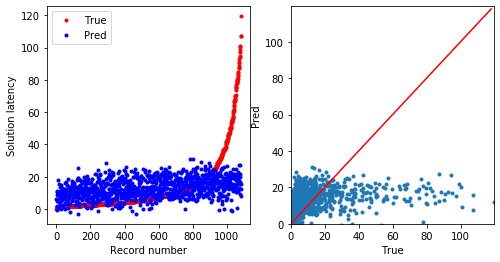

In [12]:
plot_scatter(true_Y, pred_Y[:,0])

Mean of residual: 0.018


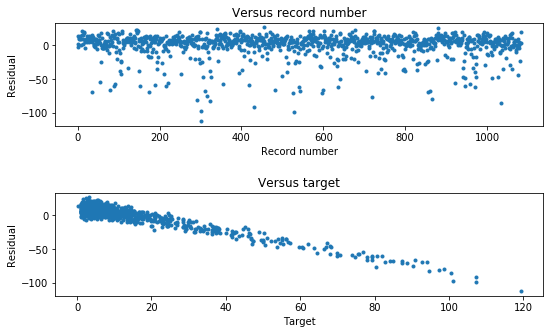

In [8]:
plot_residual(true_Y, pred_Y[:,0])

Best model so far: Correlated PCA, SMOTER, GPR

## Cross validation for each subject

In [42]:
record = {}
record['true_Y'], record['pred_Y'] = [], []
record['train_std'], record['test_std'] = [], []
record['train_r2'], record['test_r2'] = [], []
for i_sub in range(11):
    with open('./raw_data/ERSP_from_raw_%d.data'%(i_sub), 'rb') as fp:
        dict_ERSP = pickle.load(fp)

    ERSP_all, tmp_all, freqs, t = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq'], dict_ERSP['t']
    
    mode_cv = 'KFold'
    #aug_methods = ['Original', 'undersampling', 'SMOTER', 'add_noise']
    aug_methods = ['Original', 'SMOTER']
    scale_flag = False
    method = 2
    rgr_method = 3
    num_results = len(aug_methods)

    if mode_cv == 'KFold':
        num_fold = 10
        kf = KFold(n_splits=num_fold, shuffle=True, random_state=23)

    else:
        num_fold = ERSP_all.shape[0]
        kf = LeaveOneOut()

    true_Y = np.zeros(tmp_all.shape[0])
    pred_Y = np.zeros((tmp_all.shape[0], num_results))

    train_std = np.zeros((num_fold, num_results))
    test_std = np.zeros((num_fold, num_results))
    train_r2 = np.zeros((num_fold, num_results))
    test_r2 = np.zeros((num_fold, num_results))
    train_base = np.zeros(num_fold)
    test_base = np.zeros(num_fold)
    train_base_r2 = np.zeros(num_fold)
    test_base_r2 = np.zeros(num_fold)

    curr_test = 0

    for i, (train_index, test_index) in enumerate(kf.split(ERSP_all)):
        print('---Iteration %d---\n'%(i))

        # Standardize data
        X_all, Y = preprocessing.standardize(ERSP_all, tmp_all, train_indices=train_index, threshold=0.0)

        '''
        # Select correlated ERSP
        X_all, select_indices = preprocessing.select_correlated_ERSP(X_all, Y, threshold_corr=0.95, train_indices=train_index)
        select.append(select_indices)
        '''

        # Flatten X_all
        X_all = X_all.reshape((X_all.shape[0],-1))

        # Split data
        X_train, X_test_ori = X_all[train_index, :], X_all[test_index, :]
        Y_train, Y_test_ori = Y[train_index], Y[test_index]

        # Data augmentation
        aug_X_train, aug_Y_train = {}, {}

        aug_X_train['Original'], aug_Y_train['Original'] = X_train.copy(), Y_train.copy()
        if 'undersampling' in aug_methods:
            aug_X_train['undersampling'], aug_Y_train['undersampling'] = data_augmentation.aug(X_train, Y_train, 'undersampling')
        if 'SMOTER' in aug_methods:
            aug_X_train['SMOTER'], aug_Y_train['SMOTER'] = data_augmentation.aug(X_train, Y_train, 'SMOTER')
        if 'add_noise' in aug_methods:
            aug_X_train['add_noise'], aug_Y_train['add_noise'] = data_augmentation.aug(X_train, Y_train, 'add_noise', (10,1))

        for i_aug, aug_method in enumerate(aug_methods):

            X_train, Y_train = aug_X_train[aug_method], aug_Y_train[aug_method]
            X_test, Y_test = X_test_ori.copy(), Y_test_ori.copy()

            # Standardize before PCA
            if scale_flag:
                X_train, X_test = preprocessing.scale(X_train, X_test)

            # PCA
            if method == 1:
                pca = PCA(n_components=10)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
            elif method == 2:
                X_train, X_test = preprocessing.PCA_corr(X_train, Y_train, X_test=X_test, num_features=10)
            elif method == 3:
                X_train = X_train.reshape((X_train.shape[0],12,-1))
                X_test = X_test.reshape((X_test.shape[0],12,-1))

                X_train = preprocessing.bandpower(X_train, freqs, 5, 15)
                X_test = preprocessing.bandpower(X_test, freqs, 5, 15)

                X_train = X_train.reshape((X_train.shape[0],-1))
                X_test = X_test.reshape((X_test.shape[0],-1))

            if rgr_method == 1:
                rgr = LinearRegression()
            elif rgr_method == 2:
                rgr = Ridge(alpha=0.1)
            elif rgr_method == 3:
                #kernel = RBF(10, (1e-5,1e2)) + ConstantKernel(10, (1e-3,1e3))
                kernel = RBF(10, (1e-5,1e2))
                rgr = GaussianProcessRegressor(kernel=kernel, random_state=0)

            _, train_std[i,i_aug], test_std[i,i_aug], train_r2[i,i_aug], test_r2[i,i_aug], pred_train, pred_test = \
                regression(X_train, Y_train, X_test, Y_test, rgr)
            print('%s: %f | %f, %f | %f\n'%(aug_method, train_std[i,i_aug], test_std[i,i_aug], 
                                            train_r2[i,i_aug], test_r2[i,i_aug]))
            pred_Y[curr_test:curr_test+len(test_index), i_aug] = pred_test

        true_Y[curr_test:curr_test+len(test_index)] = Y_test
        curr_test += len(test_index)

    record['true_Y'].append(true_Y)
    record['pred_Y'].append(pred_Y)
    record['train_std'].append(train_std)
    record['test_std'].append(test_std)
    record['train_r2'].append(train_r2)
    record['test_r2'].append(test_r2)


---Iteration 0---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 20.007209
Data: (56, 684) -> (112, 684)
Target: (56,) -> (112,)
1. 0.348
2. 0.216
3. 0.207
4. 0.199
5. 0.198
6. 0.195
7. 0.186
8. 0.172
9. 0.166
10. 0.158
Original: 0.000000 | 20.096394, 1.000000 | -1.838136

1. 0.249
2. 0.230
3. 0.228
4. 0.207
5. 0.193
6. 0.180
7. 0.179
8. 0.162
9. 0.159
10. 0.145
SMOTER: 0.000000 | 13.153401, 1.000000 | -0.215830

---Iteration 1---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 17.576947
Data: (56, 684) -> (101, 684)
Target: (56,) -> (101,)
1. 0.303
2. 0.296
3. 0.285
4. 0.278
5. 0.255
6. 0.243
7. 0.212
8. 0.201
9. 0.184
10. 0.141
Original: 0.000000 | 39.526241, 1.000000 | -0.836294

1. 0.264
2. 0.258
3. 0.214
4. 0.197
5. 0.194
6. 0.183
7. 0.171
8. 0.155
9. 0.149
10. 0.149
SMOTER: 0.000000 | 38.788629, 1.0000

Original: 0.000000 | 39.556865, 1.000000 | -0.001272

1. 0.312
2. 0.259
3. 0.227
4. 0.190
5. 0.189
6. 0.187
7. 0.169
8. 0.169
9. 0.162
10. 0.155
SMOTER: 0.000000 | 38.510032, 1.000000 | 0.051022

---Iteration 7---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 17.660459
Data: (68, 684) -> (108, 684)
Target: (68,) -> (108,)
1. 0.269
2. 0.263
3. 0.248
4. 0.223
5. 0.219
6. 0.202
7. 0.183
8. 0.167
9. 0.165
10. 0.152
Original: 0.000000 | 24.157163, 1.000000 | -0.024929

1. 0.304
2. 0.302
3. 0.274
4. 0.248
5. 0.199
6. 0.177
7. 0.168
8. 0.152
9. 0.151
10. 0.148
SMOTER: 0.000000 | 29.105351, 1.000000 | -0.487810

---Iteration 8---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 18.200669
Data: (68, 684) -> (108, 684)
Target: (68,) -> (108,)
1. 0.267
2. 0.248
3. 0.232
4. 0.221
5. 0.221
6. 0.196
7. 0.192
8. 0.189
9. 0.182
10. 0.178
Original: 0.0

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


---Iteration 0---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 8.169256
Data: (156, 684) -> (389, 684)
Target: (156,) -> (389,)
1. 0.222
2. 0.213
3. 0.181
4. 0.174
5. 0.172
6. 0.170
7. 0.169
8. 0.160
9. 0.150
10. 0.149
Original: 0.000000 | 11.459900, 1.000000 | -0.577556

1. 0.378
2. 0.312
3. 0.239
4. 0.239
5. 0.213
6. 0.209
7. 0.164
8. 0.143
9. 0.143
10. 0.128
SMOTER: 0.000001 | 9.945331, 1.000000 | -0.188124

---Iteration 1---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 6.183736
Data: (156, 684) -> (276, 684)
Target: (156,) -> (276,)
1. 0.201
2. 0.192
3. 0.182
4. 0.181
5. 0.171
6. 0.155
7. 0.148
8. 0.142
9. 0.138
10. 0.135
Original: 0.000000 | 7.203036, 1.000000 

/Users/hundredball/anaconda3/envs/Math24/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


SMOTER: 0.000001 | 4.407452, 1.000000 | -3.752673

---Iteration 6---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 8.344675
Data: (157, 684) -> (384, 684)
Target: (157,) -> (384,)
1. 0.260
2. 0.193
3. 0.184
4. 0.172
5. 0.165
6. 0.160
7. 0.152
8. 0.152
9. 0.152
10. 0.149
Original: 0.000000 | 5.326224, 1.000000 | -1.739621

1. 0.280
2. 0.274
3. 0.264
4. 0.263
5. 0.225
6. 0.219
7. 0.210
8. 0.138
9. 0.137
10. 0.134
SMOTER: 0.000001 | 5.810952, 1.000000 | -2.260965

---Iteration 7---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 8.462332
Data: (157, 684) -> (396, 684)
Target: (157,) -> (396,)
1. 0.209
2. 0.191
3. 0.191
4. 0.172
5. 0.169
6. 0.160
7. 0.154
8. 0.153
9. 0.152
10. 0.147
Original: 0.000000 | 3.424127, 1.000000 | -2.2

Original: 0.000000 | 38.518155, 1.000000 | -13.767817

1. 0.390
2. 0.308
3. 0.286
4. 0.283
5. 0.188
6. 0.186
7. 0.165
8. 0.160
9. 0.158
10. 0.143
SMOTER: 0.000000 | 16.182465, 1.000000 | -1.606602

---Iteration 3---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 22.565250
Data: (44, 684) -> (58, 684)
Target: (44,) -> (58,)
1. 0.349
2. 0.258
3. 0.241
4. 0.220
5. 0.209
6. 0.183
7. 0.182
8. 0.180
9. 0.179
10. 0.178
Original: 0.000000 | 27.578169, 1.000000 | 0.027678

1. 0.344
2. 0.262
3. 0.258
4. 0.245
5. 0.207
6. 0.204
7. 0.177
8. 0.159
9. 0.156
10. 0.156
SMOTER: 0.000000 | 28.882702, 1.000000 | -0.066485

---Iteration 4---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 25.249180
Data: (44, 684) -> (55, 684)
Target: (44,) -> (55,)
1. 0.343
2. 0.336
3. 0.272
4. 0.267
5. 0.265
6. 0.228
7. 0.198
8. 0.178
9. 0.170
10. 0.127
Original: 0.0000

---Iteration 0---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 10.065035
Data: (101, 684) -> (167, 684)
Target: (101,) -> (167,)
1. 0.286
2. 0.203
3. 0.173
4. 0.165
5. 0.161
6. 0.161
7. 0.158
8. 0.158
9. 0.153
10. 0.150
Original: 0.000000 | 6.731816, 1.000000 | -2.414351

1. 0.246
2. 0.237
3. 0.236
4. 0.201
5. 0.195
6. 0.185
7. 0.164
8. 0.158
9. 0.156
10. 0.154
SMOTER: 0.000000 | 6.731816, 1.000000 | -2.414351

---Iteration 1---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 10.041224
Data: (101, 684) -> (161, 684)
Target: (101,) -> (161,)
1. 0.260
2. 0.230
3. 0.206
4. 0.204
5. 0.188
6. 0.187
7. 0.174
8. 0.169
9. 0.166
10. 0.158
Original: 0.000000 | 7.390564, 1.000000 | -1.727166

1. 0.322
2. 0.225
3. 0.224
4. 0.208
5. 0.1

SMOTER: 0.000000 | 13.731380, 1.000000 | -0.272095

---Iteration 7---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 17.194255
Data: (56, 684) -> (84, 684)
Target: (56,) -> (84,)
1. 0.279
2. 0.265
3. 0.226
4. 0.219
5. 0.211
6. 0.208
7. 0.197
8. 0.187
9. 0.176
10. 0.159
Original: 0.000000 | 9.175955, 1.000000 | 0.351073

1. 0.315
2. 0.307
3. 0.298
4. 0.242
5. 0.231
6. 0.181
7. 0.177
8. 0.175
9. 0.174
10. 0.169
SMOTER: 0.000003 | 11.739707, 1.000000 | -0.062204

---Iteration 8---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
Number of minor equals to 0
> After SMOTER
Mean of all trials: 17.786850
Data: (56, 684) -> (71, 684)
Target: (56,) -> (71,)
1. 0.286
2. 0.271
3. 0.265
4. 0.251
5. 0.224
6. 0.221
7. 0.220
8. 0.212
9. 0.196
10. 0.186
Original: 0.000000 | 22.297483, 1.000000 | -34.898606

1. 0.365
2. 0.304
3. 0.270
4. 0.268
5. 0.267
6. 0.22

> After SMOTER
Mean of all trials: 22.044494
Data: (59, 684) -> (76, 684)
Target: (59,) -> (76,)
1. 0.321
2. 0.285
3. 0.273
4. 0.220
5. 0.216
6. 0.207
7. 0.195
8. 0.186
9. 0.175
10. 0.166
Original: 0.000000 | 35.422697, 1.000000 | -2.742498

1. 0.389
2. 0.334
3. 0.334
4. 0.255
5. 0.211
6. 0.188
7. 0.178
8. 0.167
9. 0.162
10. 0.152
SMOTER: 0.000000 | 19.416199, 1.000000 | -0.124415

---Iteration 6---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
Number of minor equals to 0
> After SMOTER
Mean of all trials: 21.839624
Data: (59, 684) -> (76, 684)
Target: (59,) -> (76,)
1. 0.385
2. 0.307
3. 0.245
4. 0.230
5. 0.225
6. 0.218
7. 0.182
8. 0.165
9. 0.163
10. 0.155
Original: 0.000000 | 32.425255, 1.000000 | -1.087569

1. 0.343
2. 0.308
3. 0.250
4. 0.244
5. 0.220
6. 0.201
7. 0.184
8. 0.184
9. 0.178
10. 0.175
SMOTER: 0.000000 | 32.364851, 1.000000 | -1.079799

---Iteration 7---

Base threshold: 0.000000
--- Data Augmentation (SMOTER) ---
> After SMOTER
Mean of all trials: 21.199476

Subject 0, Original: std (0.000000, 21.586030), r2 (1.000000, -1.308549)
Subject 0, SMOTER: std (0.000001, 20.595655), r2 (1.000000, -1.308549)
Subject 1, Original: std (0.000000, 21.860232), r2 (1.000000, -1.308549)
Subject 1, SMOTER: std (0.000000, 23.902052), r2 (1.000000, -1.308549)
Subject 2, Original: std (0.000000, 7.133764), r2 (1.000000, -1.308549)
Subject 2, SMOTER: std (0.000000, 6.923257), r2 (1.000000, -1.308549)
Subject 3, Original: std (0.000000, 14.278762), r2 (1.000000, -1.308549)
Subject 3, SMOTER: std (0.000000, 14.278762), r2 (1.000000, -1.308549)
Subject 4, Original: std (0.000000, 32.489016), r2 (1.000000, -1.308549)
Subject 4, SMOTER: std (0.000000, 28.417193), r2 (1.000000, -1.308549)
Subject 5, Original: std (0.000000, 24.337689), r2 (1.000000, -1.308549)
Subject 5, SMOTER: std (0.000002, 22.647127), r2 (1.000000, -1.308549)
Subject 6, Original: std (0.000000, 10.292321), r2 (1.000000, -1.308549)
Subject 6, SMOTER: std (0.000000, 10.279203), r2 (1.000000, -1.30

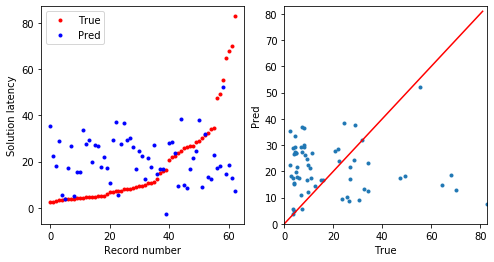

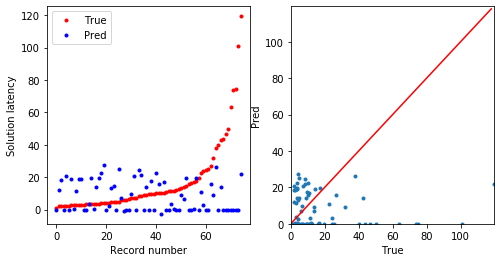

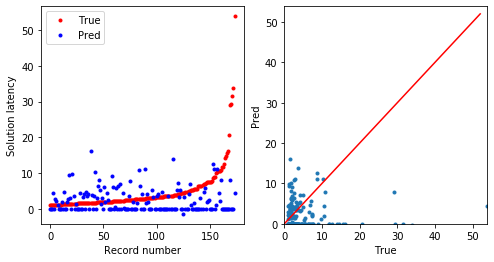

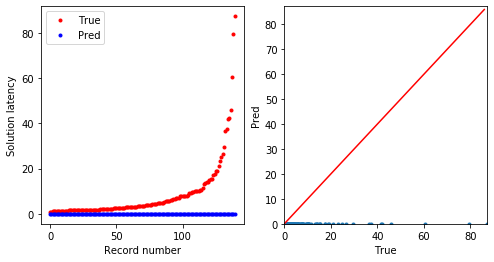

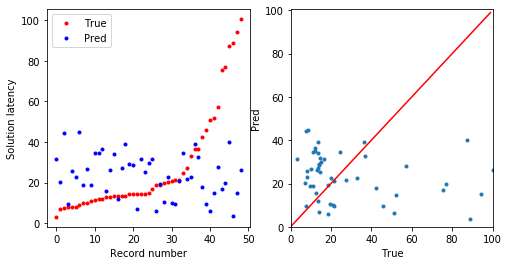

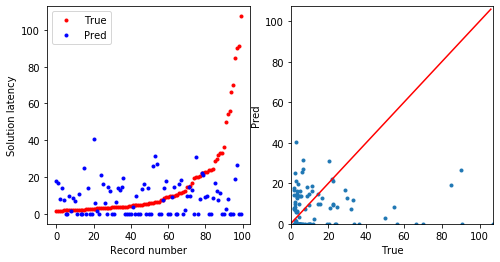

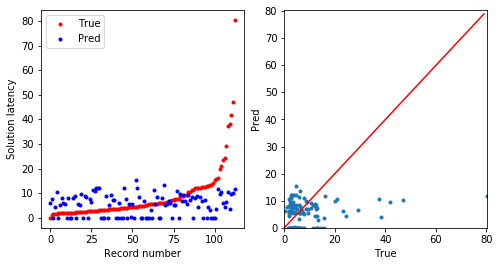

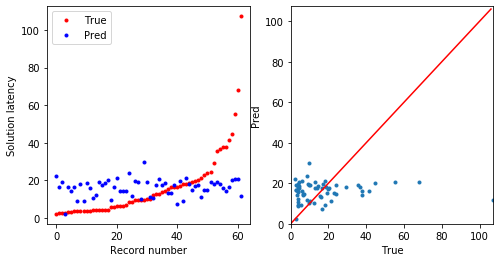

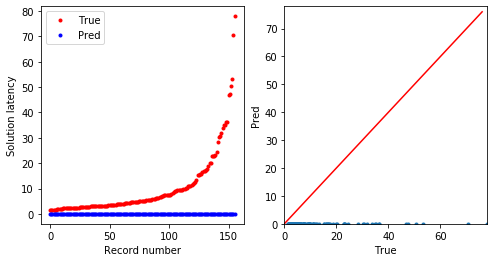

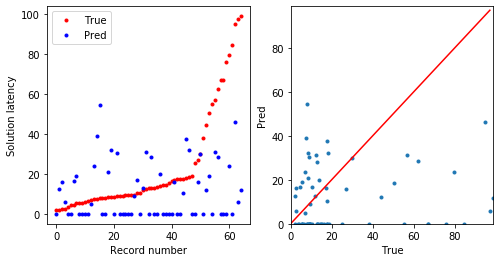

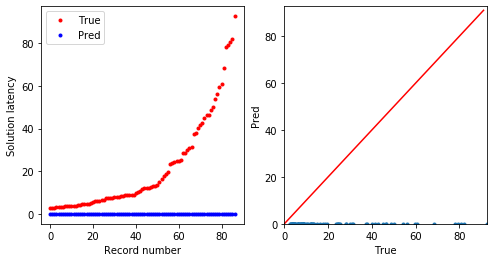

In [43]:
for i_sub in range(11):
    train_std = record['train_std'][i_sub]
    test_std = record['test_std'][i_sub]
    train_r2 = record['train_r2'][i_sub]
    test_std = record['test_std'][i_sub]
    true_Y = record['true_Y'][i_sub]
    pred_Y = record['pred_Y'][i_sub]
    
    for i, aug_method in enumerate(aug_methods):
        print('Subject %d, %s: std (%f, %f), r2 (%f, %f)'%(i_sub, aug_method, \
            np.mean(train_std[:,i]), np.mean(test_std[:,i]), np.mean(train_r2[:,i]), np.mean(test_r2[:,i])))
        
    plot_scatter(true_Y, pred_Y[:,1], 'PreData_sub%d'%(i_sub))

## All data analysis

Base threshold: 5.000000
1. 0.192
2. 0.175


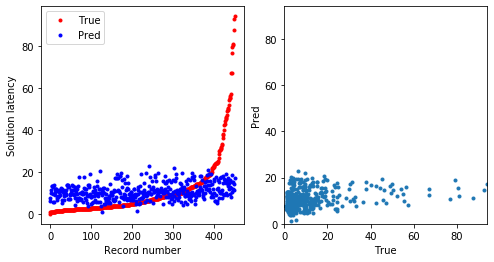

In [13]:
X, Y = preprocessing.standardize(ERSP_all, tmp_all, threshold=float(5))

# X, select_indices = preprocessing.select_correlated_ERSP(X, Y, threshold_corr=0.75)
X = X.reshape((X.shape[0],-1))

X = preprocessing.PCA_corr(X, Y, num_features=2)
rgr = LinearRegression()
rgr.fit(X, Y)

pred_Y = rgr.predict(X)

plot_scatter(Y, pred_Y)

In [ ]:
std_list = []
r2_list = []
for remove_threshold in range(2,80,2):
    
    X_train, Y_train = preprocessing.remove_trials(ERSP_all, SLs, remove_threshold)
    
    pca = PCA(n_components=0.9)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    
    rgr = svm.SVR()
    rgr.fit(X_train, Y_train)
    pred_Y = rgr.predict(X_train)
    
    error = standard_error(Y_train, pred_Y)
    r2 = r2_score(Y_train, pred_Y)
    std_list.append(error)
    r2_list.append(r2)
    print('%d: %f, %f'%(remove_threshold, error, r2))

(array([ 3., 50., 56., 54., 38., 24., 22., 21., 16., 21., 19.,  7., 11.,
        12.,  6.,  9.,  6.,  4.,  6.,  6.,  4.,  1.,  1.,  4.,  2.,  7.,
         2.,  0.,  1.,  0.,  1.,  1.,  2.,  3.,  1.,  1.,  0.,  0.,  1.,
         0.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  2.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.15234375,  1.091875  ,  2.03140625,  2.9709375 ,  3.91046875,
         4.85      ,  5.78953125,  6.7290625 ,  7.66859375,  8.608125  ,
         9.54765625, 10.4871875 , 11.42671875, 12.36625   , 13.30578125,
        14.2453125 , 15.18484375, 16.124375  , 17.06390625, 18.0034375 ,
        18.94296875, 19.8825    , 20.82203125, 21.7615625 , 22.70109375,
        23.640625  , 24.58015625, 25.5196875 , 26.45921875, 27.39875 

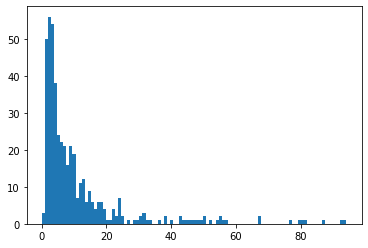

In [18]:
plt.hist(SLs, bins=100)

In [10]:
SLs = tmp_all[:,2]
np.sum(SLs<=np.quantile(SLs, 0.2))/len(SLs)

0.2013274336283186

In [8]:
np.quantile(SLs, 0.25)

3.02001953125